In [ ]:
!kaggle datasets download -d jessicali9530/celeba-dataset
!unzip /content/celeba-dataset.zip

Streaming output truncated to the last 5000 lines.

  inflating: img_align_celeba/img_align_celeba/197604.jpg  

  inflating: img_align_celeba/img_align_celeba/197605.jpg  

  inflating: img_align_celeba/img_align_celeba/197606.jpg  

  inflating: img_align_celeba/img_align_celeba/197607.jpg  

  inflating: img_align_celeba/img_align_celeba/197608.jpg  

  inflating: img_align_celeba/img_align_celeba/197609.jpg  

  inflating: img_align_celeba/img_align_celeba/197610.jpg  

  inflating: img_align_celeba/img_align_celeba/197611.jpg  

  inflating: img_align_celeba/img_align_celeba/197612.jpg  

  inflating: img_align_celeba/img_align_celeba/197613.jpg  

  inflating: img_align_celeba/img_align_celeba/197614.jpg  

  inflating: img_align_celeba/img_align_celeba/197615.jpg  

  inflating: img_align_celeba/img_align_celeba/197616.jpg  

  inflating: img_align_celeba/img_align_celeba/197617.jpg  

  inflating: img_align_celeba/img_align_celeba/197618.jpg  

  inflating: img_align_celeba/img

In [ ]:
!wget https://drive.google.com/file/d/1ndtYb3tlopQhpBYUHpBpVPYBFbz9-kb_/view?usp=drive_link

--2024-10-11 16:17:43--  https://drive.google.com/file/d/1ndtYb3tlopQhpBYUHpBpVPYBFbz9-kb_/view?usp=drive_link
Resolving drive.google.com (drive.google.com)... 108.177.96.113, 108.177.96.101, 108.177.96.102, ...
Connecting to drive.google.com (drive.google.com)|108.177.96.113|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘view?usp=drive_link’

view?usp=drive_link     [ <=>                ]  90.13K  --.-KB/s    in 0.02s   

2024-10-11 16:17:43 (4.47 MB/s) - ‘view?usp=drive_link’ saved [92293]



In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from tqdm import tqdm
import torchvision.datasets as datasets
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
import torchvision.utils as vutils
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
from torch.utils.data import Subset
import numpy as np
import cv2
import os
from PIL import Image
import json

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# laod json file
with open('/kaggle/input/captions/captions.json') as f:
    data = json.load(f)

In [ ]:
df = {
    'image_name':[],
    'caption':[]
}

num_samples =50000
for img_name in data.keys():
    caption = data[img_name]['overall_caption']

    df['image_name'].append(img_name)
    df['caption'].append(caption)

    if len(df['image_name']) > num_samples:
        break


import pandas as pd
df = pd.DataFrame(df)
df.head()

,image_name,caption
0,000001.jpg,The full face of this female is beamed with ha...
1,000002.jpg,There is not any eyeglasses on her face. This ...
2,000003.jpg,This guy doesn't have any beard and has no fri...
3,000004.jpg,"This person has no smile, and no eyeglasses. S..."
4,000005.jpg,"This lady has no bangs, and no glasses. This p..."


In [ ]:
from transformers import BertTokenizer, BertModel
import torch


#device'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased').to(device)

def get_text_embedding(text,device):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512).to(device)

    with torch.no_grad():
        outputs = model(**inputs)
    last_hidden_state = outputs.last_hidden_state
    text_embedding = torch.mean(last_hidden_state, dim=1)

    return text_embedding

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
from torch.utils.data import DataLoader
import numpy as np
from tqdm import tqdm

# Define batch size
batch_size = 256  # Adjust based on your GPU memory

def get_batch_embeddings(batch_texts, device):
    inputs = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True, max_length=512).to(device)

    with torch.no_grad():
        outputs = model(**inputs)
    last_hidden_state = outputs.last_hidden_state
    text_embeddings = torch.mean(last_hidden_state, dim=1)

    return text_embeddings.cpu().numpy()

# Create a DataLoader to batch your DataFrame captions
dataloader = DataLoader(df['caption'].tolist(), batch_size=batch_size)

all_embeddings = []

# Iterate over the DataLoader to process the data in batches
for batch_texts in tqdm(dataloader):
    batch_embeddings = get_batch_embeddings(batch_texts, device)
    all_embeddings.extend(batch_embeddings)  # Add individual embeddings

# Convert the list of embeddings to a DataFrame-compatible format
df['embedding'] = list(np.array(all_embeddings))  # Each row in 'embedding' will now contain a 1D array

df.head()

100%|██████████| 196/196 [01:44<00:00,  1.88it/s]


,image_name,caption,embedding
0,000001.jpg,The full face of this female is beamed with ha...,"[-0.15104625, -0.15074663, 0.11917375, -0.2902..."
1,000002.jpg,There is not any eyeglasses on her face. This ...,"[0.04721211, -0.27541643, -0.03005402, -0.2788..."
2,000003.jpg,This guy doesn't have any beard and has no fri...,"[-0.015353971, -0.0059778783, 0.09118644, -0.1..."
3,000004.jpg,"This person has no smile, and no eyeglasses. S...","[0.17097585, -0.1943448, -0.00038967797, -0.23..."
4,000005.jpg,"This lady has no bangs, and no glasses. This p...","[-0.057784494, -0.13319756, 0.16544518, -0.027..."


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LEARNING_RATE = 2e-4
BATCH_SIZE = 64
IMAGE_SIZE = 64
CHANNELS_IMG = 3
Z_DIM = 256
NUM_EPOCHS = 100
FEATURES_DISC = 64
FEATURES_GEN = 64

In [ ]:
# create dataset laoder with Dataset that take the df and base_dir
class Text2ImageDataset(Dataset):
    def __init__(self, df, base_dir, transform=None):
        self.df = df
        self.base_dir = base_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = self.df.iloc[idx]['image_name']
        img_path = os.path.join(self.base_dir, img_name)
        image = Image.open(img_path).convert("RGB")
        caption = self.df.iloc[idx]['caption']
        if self.transform:
            image = self.transform(image)

        return image,caption, torch.tensor(self.df.iloc[idx]['embedding'])

In [ ]:
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

base_dir = '/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba'
dataset = Text2ImageDataset(df, base_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

torch.Size([64, 3, 64, 64])
torch.Size([64, 768])


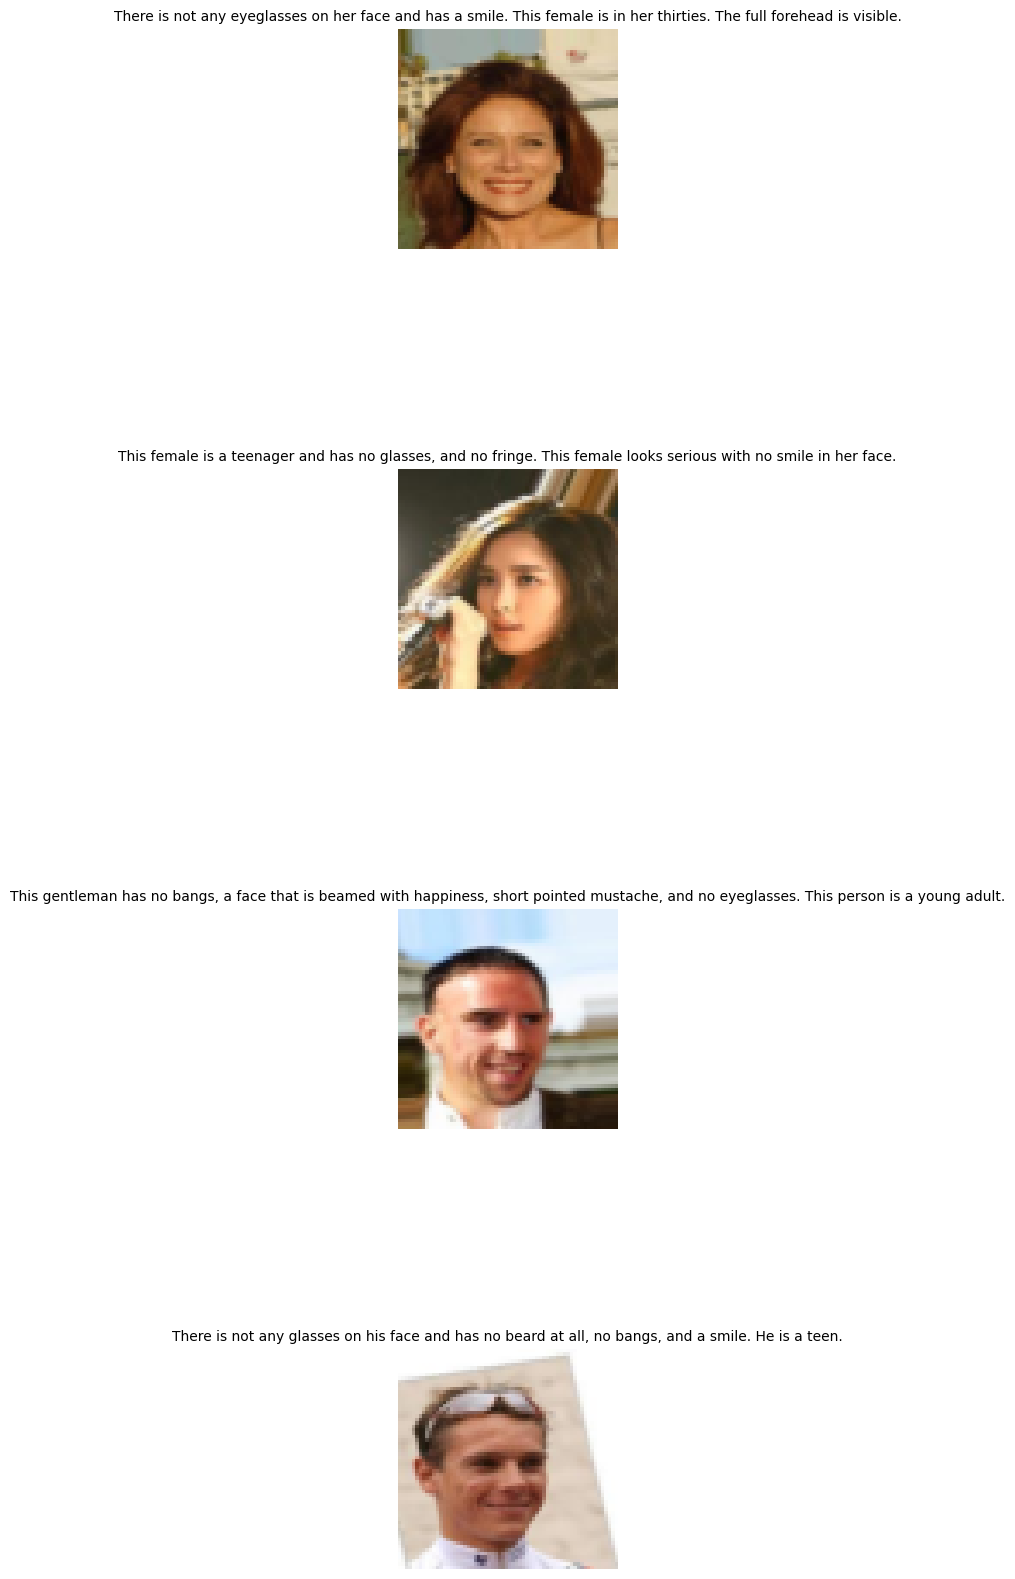

In [ ]:
real_batch = next(iter(dataloader))
image,caption,embeddings = real_batch
print(image.size())
print(embeddings.size())
# create image grids with captions on it
def show_tensor_images(image_tensor, caption, num_images=4):
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()

    nrows = num_images
    ncols = 1  # Only one column

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5, 5 * num_images))

    if nrows == 1:
        axes = [axes]

    for i in range(num_images):
        if i < len(image_unflat):
            axes[i].imshow(image_unflat[i].permute(1, 2, 0))
            axes[i].set_title(caption[i], fontsize=10)
            axes[i].axis('off')

    plt.subplots_adjust(wspace=0.1, hspace=1)  # You may increase hspace if needed
    plt.show()

show_tensor_images(image,caption)

# ResidualBlock

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(in_channels)

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += residual  # Add the input to the output (skip connection)
        out = self.relu(out)
        return out

class Generator(nn.Module):
    def __init__(self, z_dim, embeddings_dim, channels_img, features_g):
        super(Generator, self).__init__()

        # Linear layer for combining noise and embeddings
        self.embed_to_hidden = nn.Linear(z_dim + embeddings_dim, 256)

        # Adding dropout for regularization
        self.net = nn.Sequential(
            self._block(256, features_g * 8, 4, 1, 0),  # 4x4
            nn.Dropout(0.3),  # Dropout layer for regularization
            self._block(features_g * 8, features_g * 4, 4, 2, 1),
            ResidualBlock(features_g * 4),  # Residual block to maintain shape
            self._block(features_g * 4, features_g * 2, 4, 2, 1),
            ResidualBlock(features_g * 2),
            self._block(features_g * 2, features_g * 1, 4, 2, 1),
            nn.ConvTranspose2d(
                features_g, features_g, kernel_size=4, stride=2, padding=1
            ),
            nn.Conv2d(
                features_g, channels_img, kernel_size=3, stride=1, padding=1
            ),
            nn.Tanh()  # Ensures the output is between -1 and 1
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False
            ),
            nn.BatchNorm2d(out_channels),  # Normalization to stabilize training
            nn.ReLU(inplace=True)  # Activation function
        )

    def forward(self, x, embeddings):
        # Concatenate noise and embeddings
        x = torch.cat([x, embeddings], dim=1)

        # Pass through fully connected layer
        x = self.embed_to_hidden(x)
        x = x.view(x.size(0), 256, 1, 1)  # Reshape to start the ConvTranspose layers

        # Pass through the network
        return self.net(x)

In [ ]:
import torch
import torch.nn as nn

class Discriminator(nn.Module):
    def __init__(self, channels_img, embeddings_dim, features_d):
        super(Discriminator, self).__init__()

        # Convolutional layers for the image
        self.image_net = nn.Sequential(
            nn.Conv2d(channels_img, features_d, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),

            self._block(features_d, features_d * 2, 4, 2, 1),
            self._block(features_d * 2, features_d * 4, 4, 2, 1),
            self._block(features_d * 4, features_d * 8, 4, 2, 1),
            nn.Conv2d(features_d * 8, 256, kernel_size=4, stride=2, padding=0),
        )

        # Fully connected layers for combining embeddings and image features
        self.embed_to_hidden = nn.Linear(embeddings_dim, 256)

        self.final_net = nn.Sequential(
            nn.Linear(256 + 256, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 1),
            nn.Sigmoid()  # Output a probability
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2, inplace=True)
        )

    def forward(self, img, embeddings):
        # Process image with convolutional layers
        img_features = self.image_net(img).view(img.size(0), -1)  # Flatten image features

        # Process embeddings and combine with image features
        embeddings_features = self.embed_to_hidden(embeddings)

        # Concatenate image features and embeddings features
        combined = torch.cat([img_features, embeddings_features], dim=1)

        # Pass the combined features through the final layers
        output = self.final_net(combined)
        return output

In [ ]:
def initialize_weights(model):
    classname = model.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(model.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(model.weight.data, 1.0, 0.02)
        nn.init.constant_(model.bias.data, 0)

In [ ]:
gen = Generator(Z_DIM,768, CHANNELS_IMG, FEATURES_GEN).to(device)
disc = Discriminator(CHANNELS_IMG,768, FEATURES_DISC).to(device)

initialize_weights(gen)
initialize_weights(disc)

In [ ]:
real_batch = next(iter(dataloader))
image,caption,embeddings = real_batch
embeddings = embeddings.squeeze(1)
embeddings = embeddings.to(device)
image = image.to(device)

fixed_noise = torch.randn(BATCH_SIZE, Z_DIM).to(device)

print(image.size())
print(embeddings.size())
print(fixed_noise.size())

print(gen(fixed_noise,embeddings).size())

torch.Size([64, 3, 64, 64])
torch.Size([64, 768])
torch.Size([64, 256])
torch.Size([64, 3, 64, 64])


In [ ]:
# test discriminator
print(disc(image,embeddings).size())

torch.Size([64, 1])


In [ ]:
opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
opt_disc = optim.Adam(disc.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
criterion = nn.BCELoss()

fixed_noise = torch.randn(2, Z_DIM).to(device)
# select 2 random embeddings with those captions from df
fixed_embeddings = embeddings[:2]
fixed_embeddings = fixed_embeddings.to(device)
fixed_captions = caption[:2]

In [ ]:
fixed_captions

("This guy in his thirties has no beard at all, no glasses, and no smile. He doesn't have any fringe.",
 'This person has no beard. He looks extremely old and has no bangs, no smile, and no glasses.')

Epoch [1/100] Average Loss D: 0.3631, Average Loss G: 3.3135


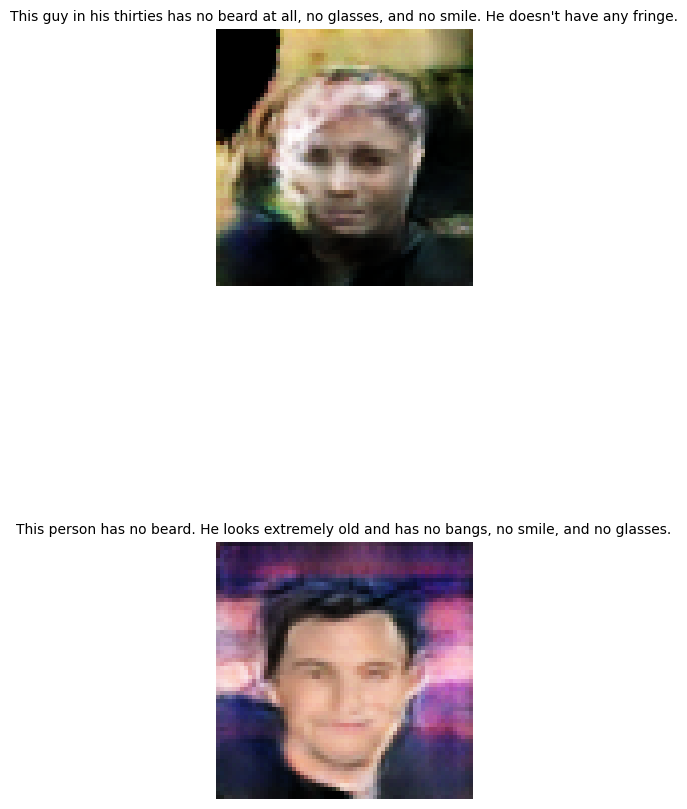

Epoch [3/100] Average Loss D: 0.3332, Average Loss G: 3.5654


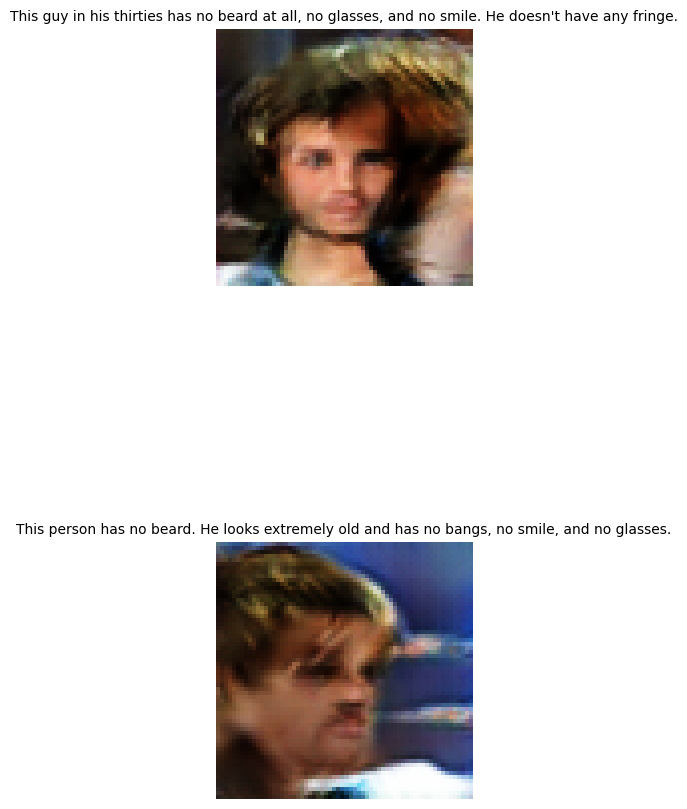

Epoch [4/100] Batch 418/782:  53%|█████▎    | 418/782 [01:39<01:29,  4.06it/s, avg_loss_D=0.327, avg_loss_G=3.56]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch [5/100] Average Loss D: 0.3227, Average Loss G: 3.6801


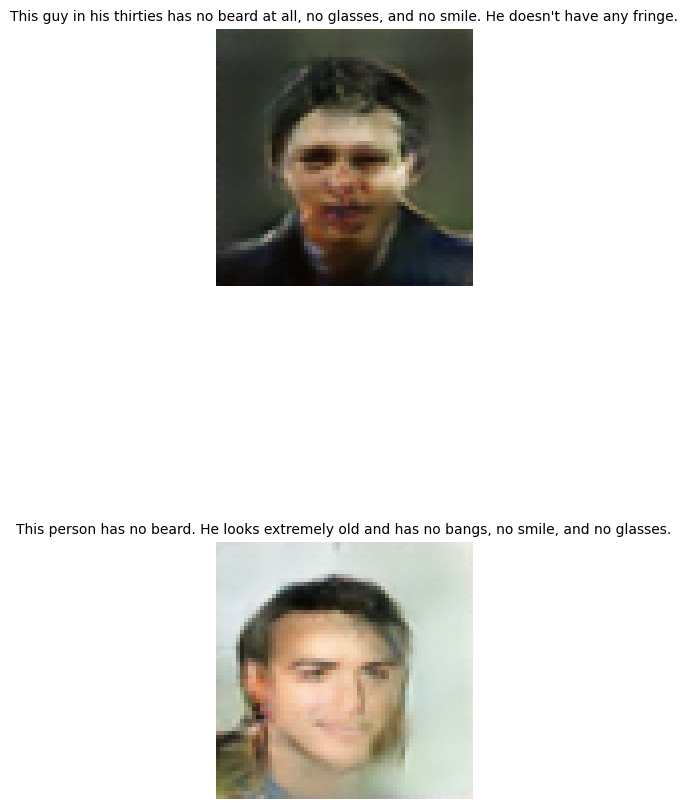

Epoch [6/100] Average Loss D: 0.3081, Average Loss G: 3.8105


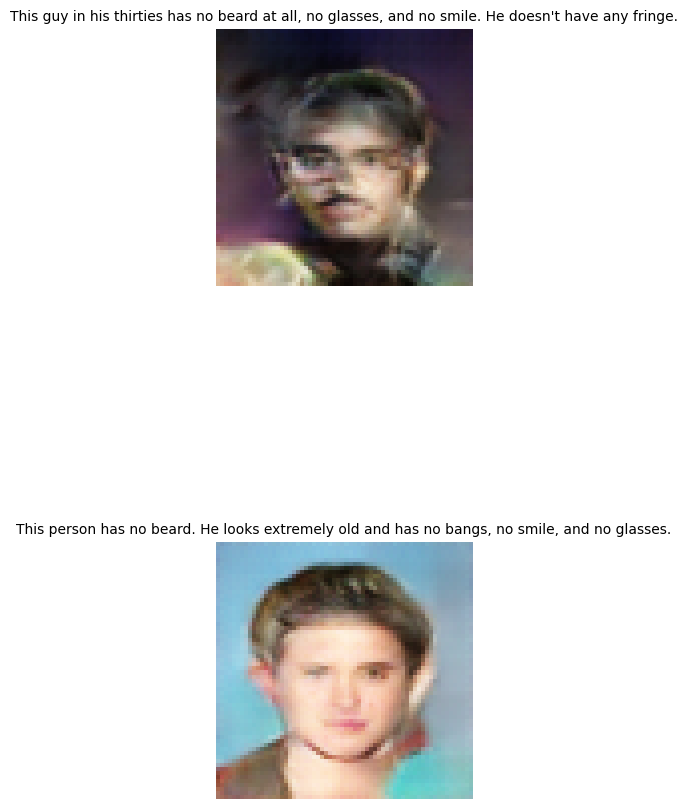

Epoch [7/100] Average Loss D: 0.3118, Average Loss G: 3.7736


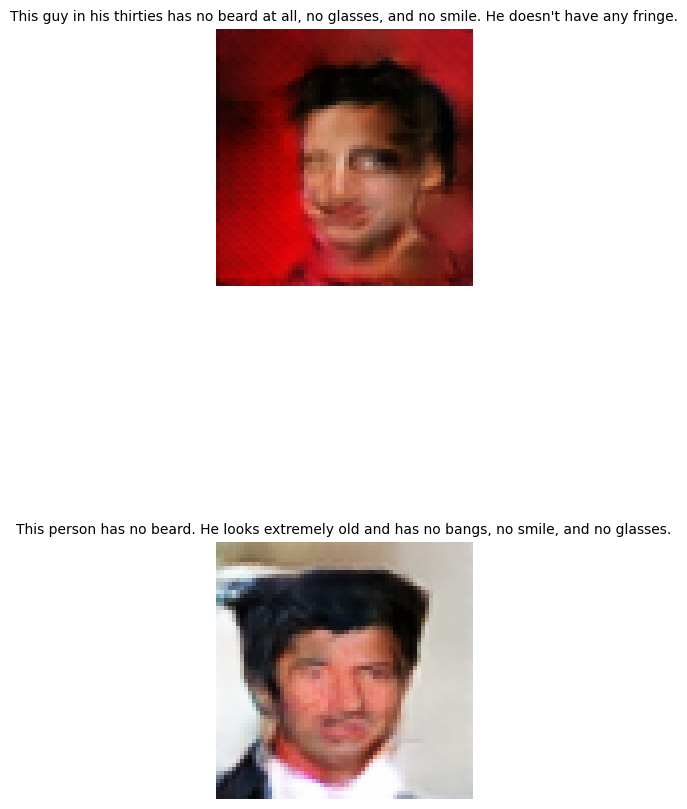

Epoch [8/100] Average Loss D: 0.2855, Average Loss G: 4.0770


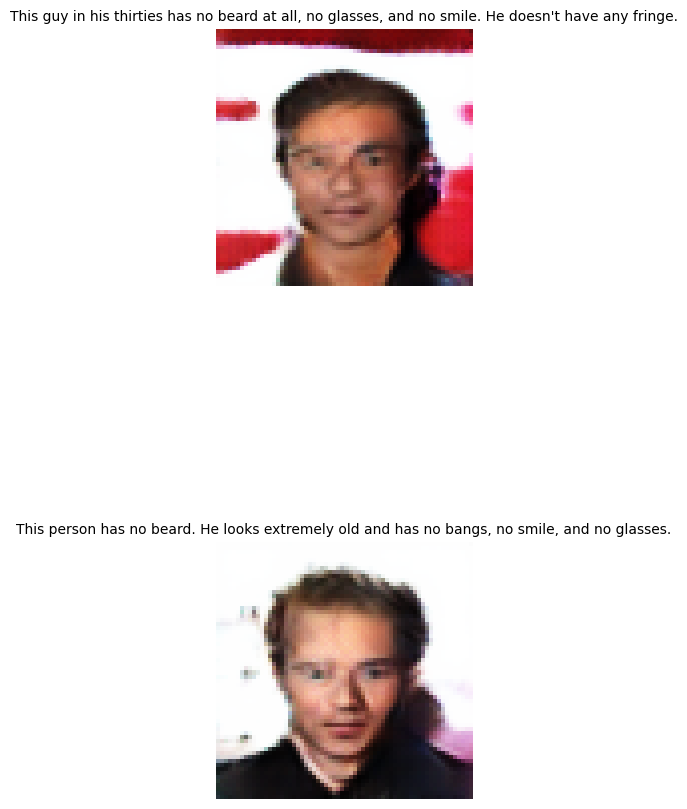

Epoch [9/100] Average Loss D: 0.2836, Average Loss G: 4.1377


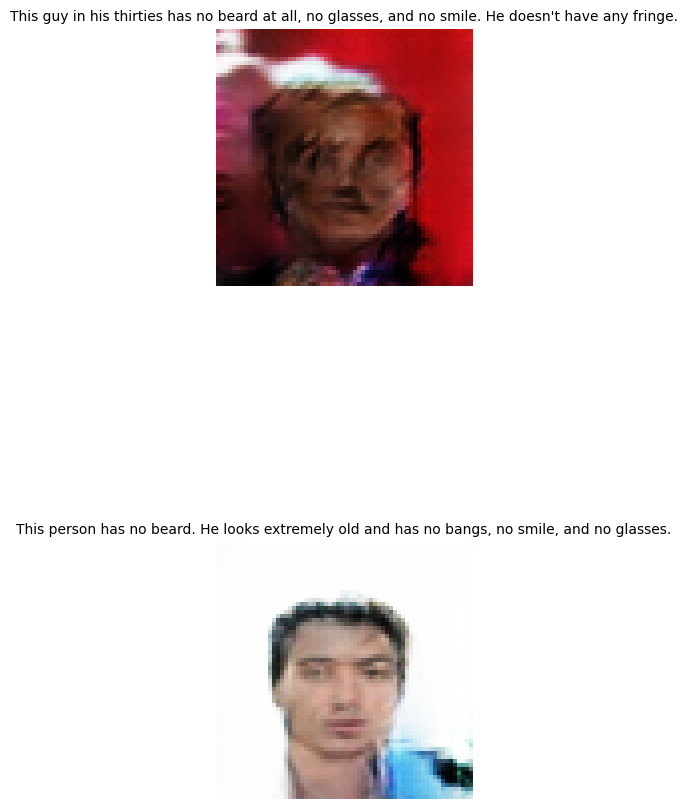

Epoch [10/100] Average Loss D: 0.2710, Average Loss G: 4.2039


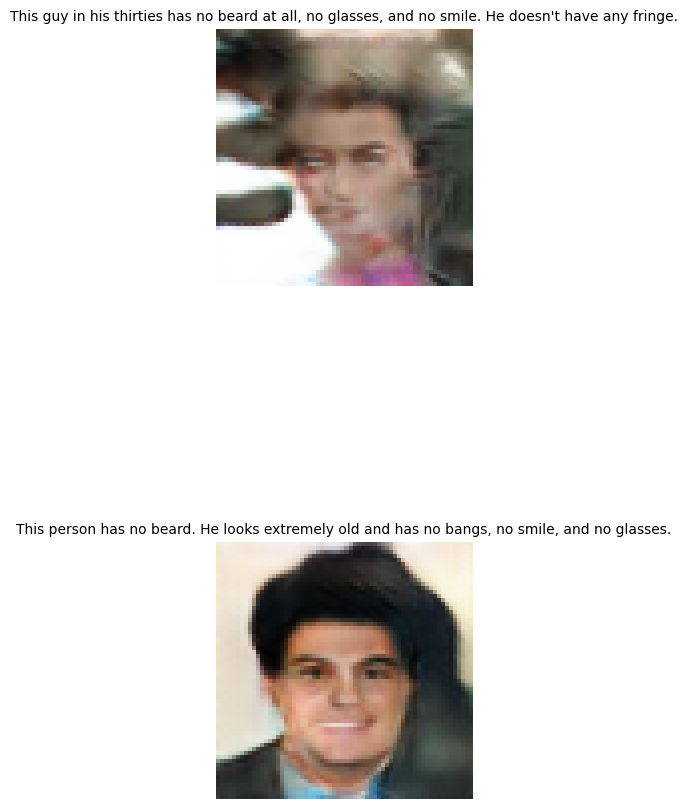

Epoch [11/100] Average Loss D: 0.2669, Average Loss G: 4.2620


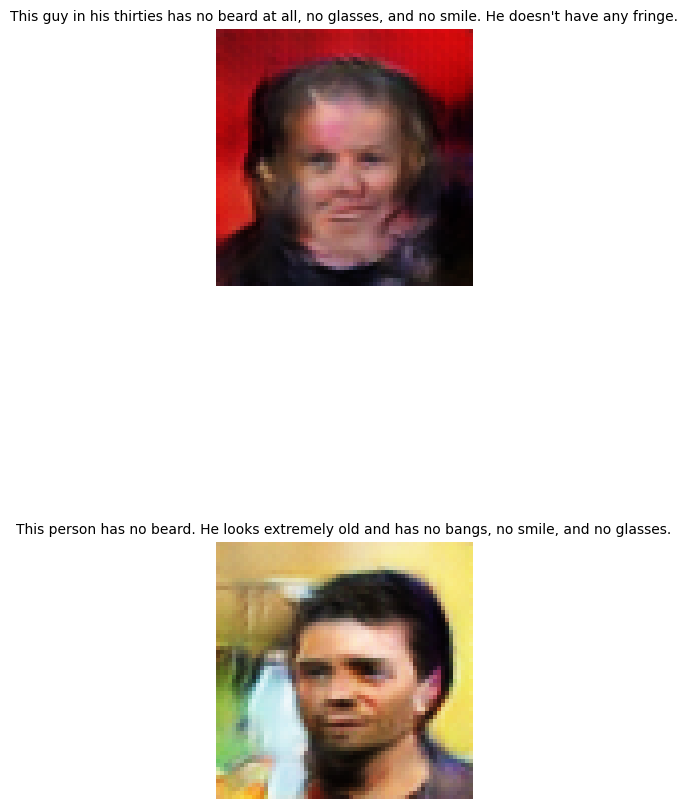

Epoch [12/100] Average Loss D: 0.2654, Average Loss G: 4.3723


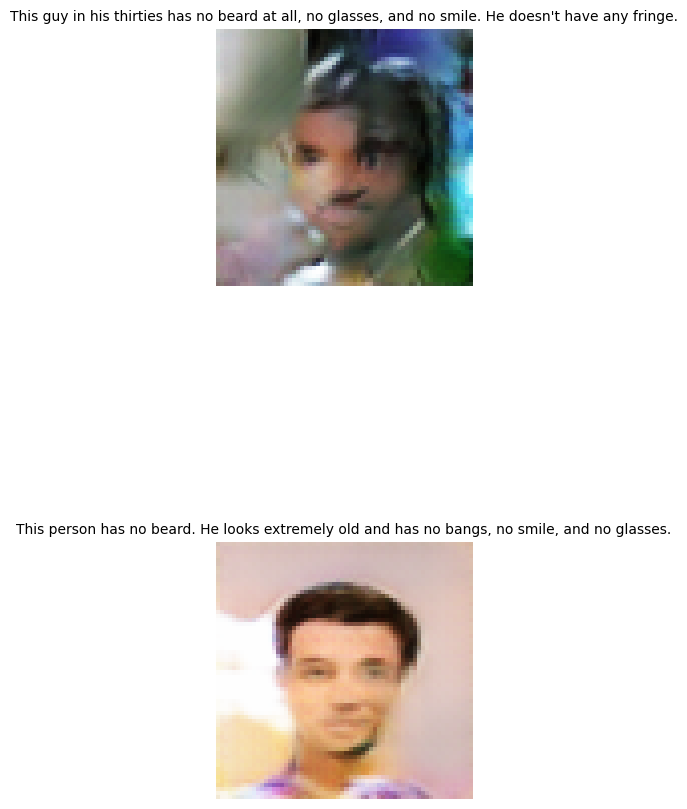

Epoch [13/100] Average Loss D: 0.2591, Average Loss G: 4.3747


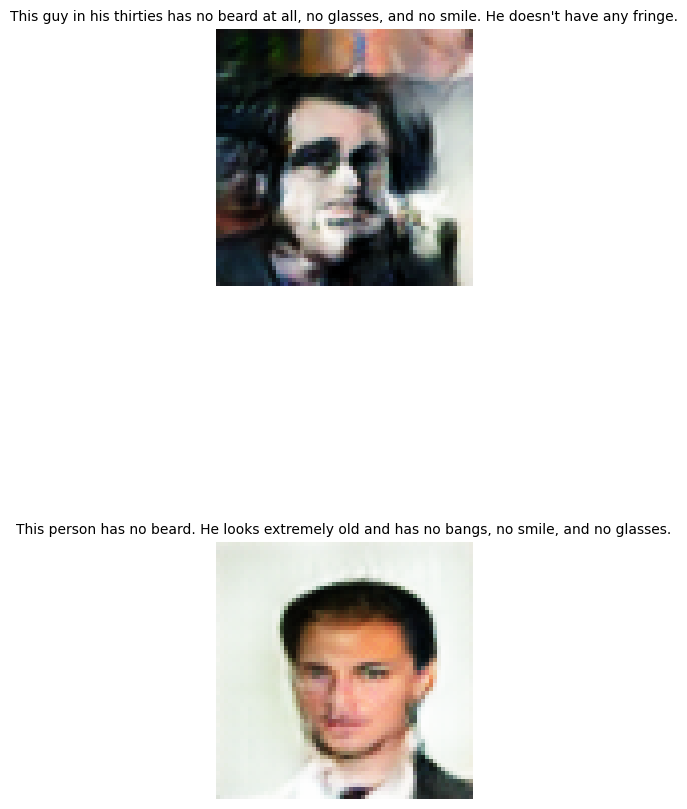

Epoch [14/100] Average Loss D: 0.2472, Average Loss G: 4.5434


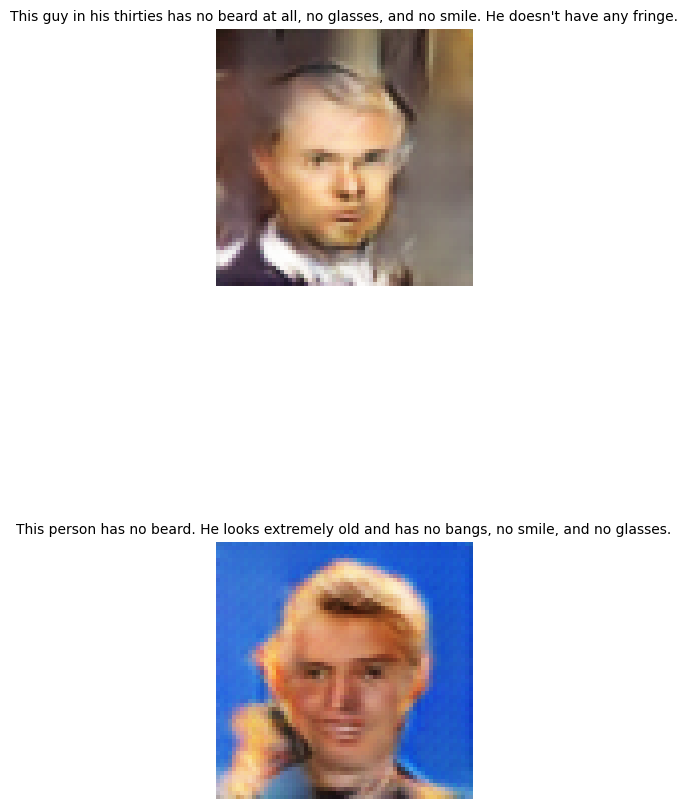

Epoch [15/100] Average Loss D: 0.2200, Average Loss G: 5.1826


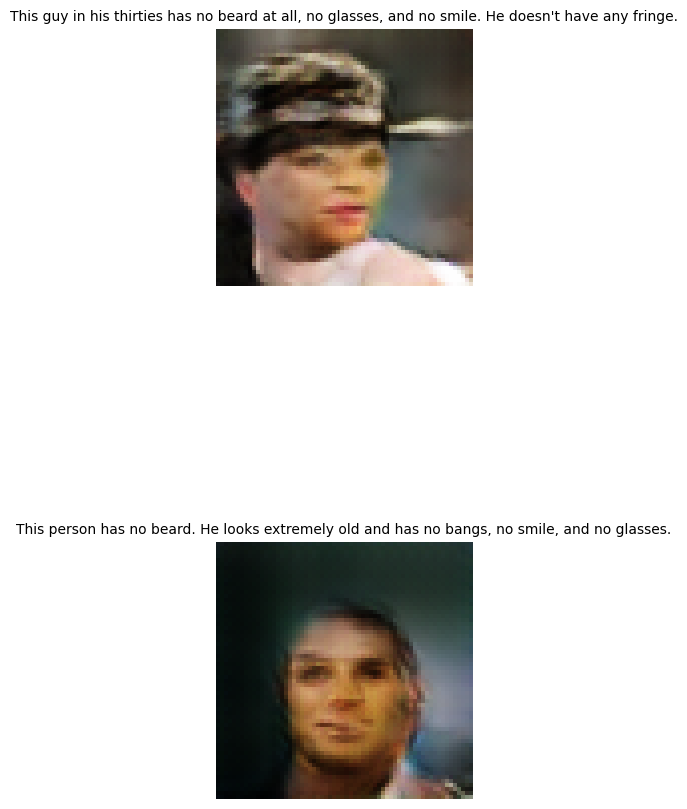

Epoch [16/100] Average Loss D: 0.2306, Average Loss G: 4.9790


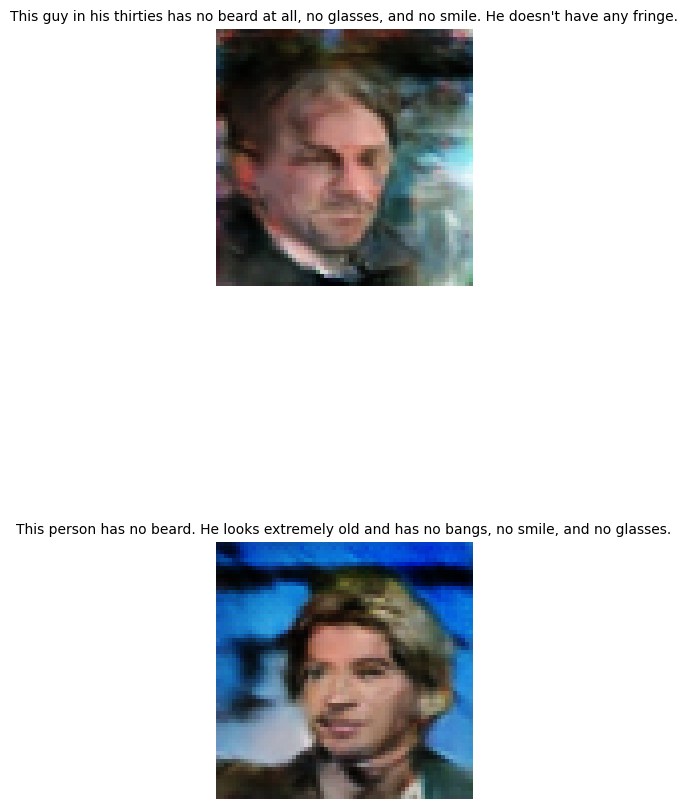

Epoch [17/100] Average Loss D: 0.2245, Average Loss G: 5.0326


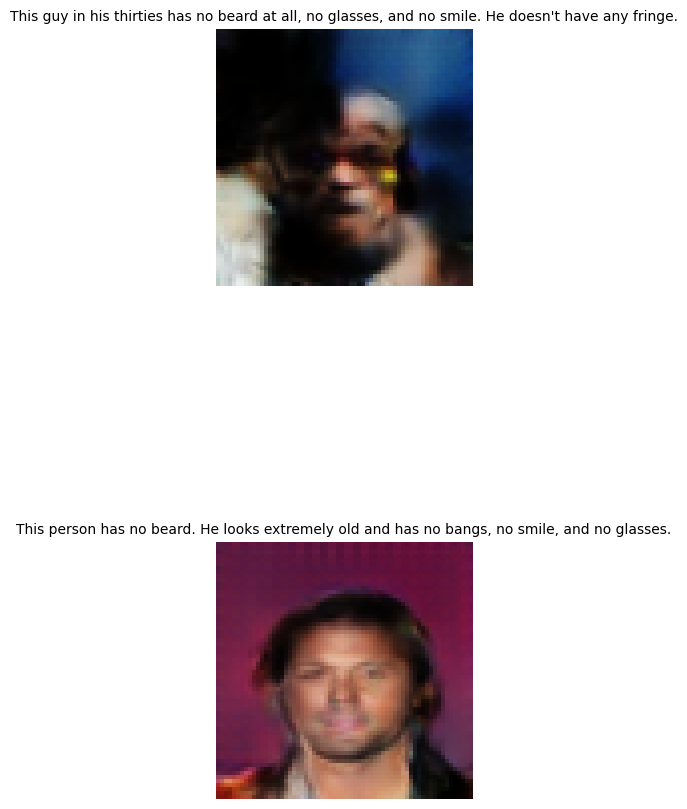

Epoch [18/100] Average Loss D: 0.2038, Average Loss G: 5.3077


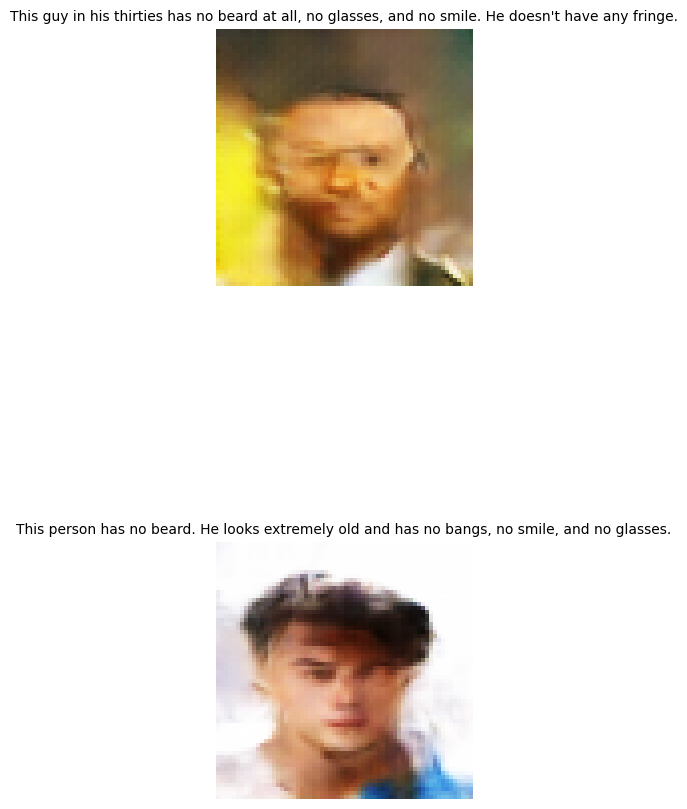

Epoch [19/100] Average Loss D: 0.2112, Average Loss G: 5.3997


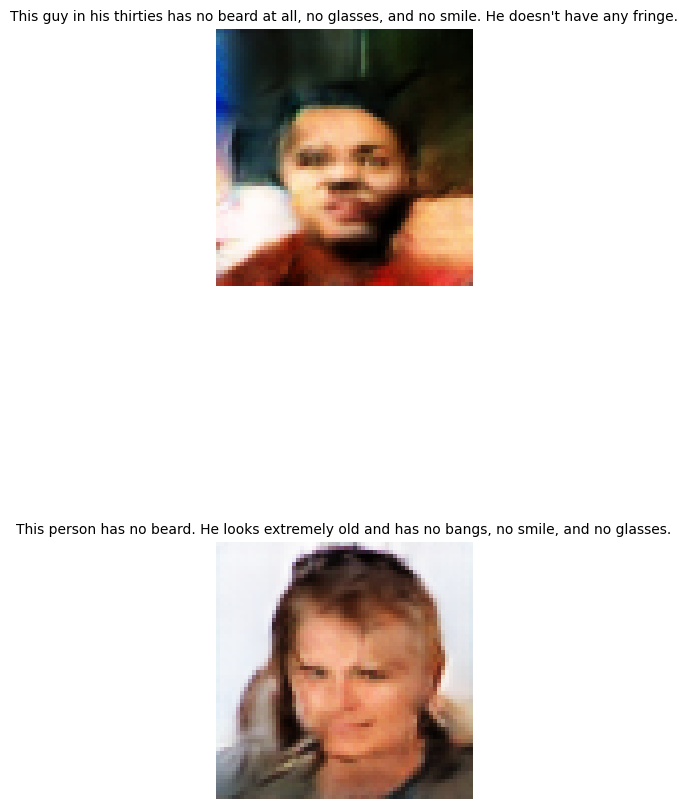

KeyboardInterrupt: 

In [ ]:
import torch
import torchvision
from tqdm import tqdm

gen.train()
disc.train()

for epoch in range(NUM_EPOCHS):
    loop = tqdm(enumerate(dataloader), total=len(dataloader), leave=False)

    # Initialize variables to accumulate losses
    loss_disc_epoch = 0
    loss_gen_epoch = 0

    for batch_idx, (real, _, embeddings) in loop:
        gen.train()
        disc.train()

        real = real.to(device)
        embeddings = embeddings.squeeze(1)
        embeddings = embeddings.to(device)

        noise = torch.randn(embeddings.shape[0], Z_DIM).to(device)

        fake = gen(noise,embeddings)

        ### Train Discriminator: max log(D(x)) + log(1 - D(G(z)))
        disc_real = disc(real,embeddings).reshape(-1)
        loss_disc_real = criterion(disc_real, torch.ones_like(disc_real))
        disc_fake = disc(fake.detach(),embeddings).reshape(-1)
        loss_disc_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
        loss_disc = (loss_disc_real + loss_disc_fake) / 2
        disc.zero_grad()
        loss_disc.backward()
        opt_disc.step()

        ### Train Generator: min log(1 - D(G(z))) <-> max log(D(G(z)))
        output = disc(fake,embeddings).reshape(-1)
        loss_gen = criterion(output, torch.ones_like(output))
        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()

        # Accumulate losses for averaging
        loss_disc_epoch += loss_disc.item()
        loss_gen_epoch += loss_gen.item()

        # Update tqdm description with average losses so far in the epoch
        avg_loss_disc = loss_disc_epoch / (batch_idx + 1)
        avg_loss_gen = loss_gen_epoch / (batch_idx + 1)
        loop.set_description(
            f"Epoch [{epoch + 1}/{NUM_EPOCHS}] Batch {batch_idx}/{len(dataloader)}"
        )
        loop.set_postfix(avg_loss_D=avg_loss_disc, avg_loss_G=avg_loss_gen)

    # Print the average losses after each epoch
    print(f"Epoch [{epoch + 1}/{NUM_EPOCHS}] Average Loss D: {avg_loss_disc:.4f}, Average Loss G: {avg_loss_gen:.4f}")

    # Evaluation after each epoch
    gen.eval()
    with torch.no_grad():
        fake = gen(fixed_noise,fixed_embeddings)
        show_tensor_images(fake,fixed_captions,num_images=2)

    # Save the model after each epoch
    torch.save(gen.state_dict(), 'gen.pth')
    torch.save(disc.state_dict(), 'disc.pth')


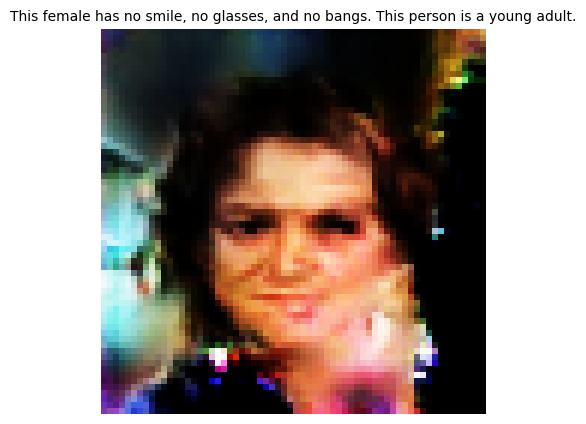

In [ ]:
text = 'This female has no smile, no glasses, and no bangs. This person is a young adult.'
text_embedding = get_text_embedding(text,device)
text_embedding = text_embedding.to(device)
noise = torch.randn(1, Z_DIM).to(device)
with torch.no_grad():
    fake = gen(noise,text_embedding)
    show_tensor_images(fake,[text],num_images=1)